# Exploring the Data

### Introduction

Now that we have properly coerced our data, it's time for us to start exploring our data.  As we'll see, with our data properly formatted, exploring the data will be easier -- and importantly more accurate. 

### Loading our data

In [45]:
from sqlalchemy import create_engine
# change the jeffreykatz to your postgres username
conn_string = 'postgresql://jeffreykatz@localhost/ecommerce'
engine = create_engine(conn_string)

In [59]:
import pandas as pd
transactions_df = pd.read_sql("select * from transactions", engine)
transactions_df[:2]

,index,transaction_id,customer_id,product,gender,device_type,country,state,city,category,...,delivery_type,quantity,transaction_start,transaction_result,amount,individual_price,month,week,dow,hour
0,0,40170,1348959766,Hair Band,Female,Web,United States,New York,New York City,Accessories,...,one-day deliver,12,1,0,6910.0,576.0,11.0,46.0,4.0,22.0
1,1,33374,2213674919,Hair Band,Female,Web,United States,California,Los Angles,Accessories,...,one-day deliver,17,1,1,1699.0,100.0,5.0,19.0,6.0,6.0


### Starting an analysis

When performing data analysis the first step is to find at least one metric we are trying to optimize.  For example, profit.

Let's look at the columns above to see if there is a component like that.

In [60]:
transactions_df.columns

Index(['index', 'transaction_id', 'customer_id', 'product', 'gender',
       'device_type', 'country', 'state', 'city', 'category',
       'customer_login_type', 'delivery_type', 'quantity', 'transaction_start',
       'transaction_result', 'amount', 'individual_price', 'month', 'week',
       'dow', 'hour'],
      dtype='object')

Looking at the columns, above, there is nothing that says profit -- but perhaps amount is really the revenue.  If we select the columns of `quantity`, `indidivual_price`, and `amount`, we see that the individual_price times the quantity does (almost) equal the amount.

In [61]:
selected_cols = transactions_df[['quantity', 'individual_price', 'amount']]
selected_cols[:2]

,quantity,individual_price,amount
0,12,576.0,6910.0
1,17,100.0,1699.0


Ok, so we have identified *amount* as a metric we can try to optimize.  The attribute we are trying to optimize is called the **target**.

Now the other information in our dataset, we can use to determine how to promote more revenue.  For example, maybe we will find that individuals from a certain location purchase more than others, or that certain products are particularly profitable in certain regions.  

These components that influence our target are our **features**.  We can think of our features as inputs that influence our target -- here revenue.

> It may be good to see what is the dimension we are trying to optimize revenue across - for example revenue per month, or revenue per customer.  But oftentimes the problems are not so well defined, so let's hold off on that for now.

### Seeing the influence

Now to see what is valuable in influencing our revenue.  For example, if there let's see which weeks we have the most amount of revenue.

In [62]:
query = """select week, sum(amount) total_amount 
from transactions group by week order by week"""
df = pd.read_sql(query, engine)
df[:2]


,week,total_amount
0,1.0,3624522.0
1,2.0,9666250.0


So we just group by the week and can order by that week to see the data sequentially.

<AxesSubplot: >

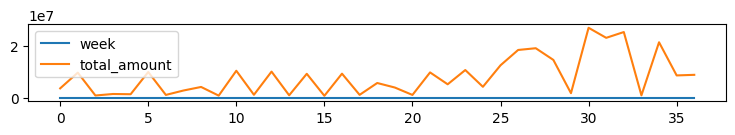

In [63]:
df.plot(figsize=(9, 1))

### Moving this to a function

Now the above group by is something we likely want to explore with all of our attributes.  So let's move this into a function.

In [85]:
def build_grouped_by(table_name, col, target, engine, order_by_col = False):
    if order_by_col:
        query = f"""select {col}, sum({target}) total_amount from {table_name} group by {col} order by {col} asc"""
    else:
        query = f"""select {col}, sum({target}) total_amount from {table_name} group by {col} order by total_amount desc"""
    grouped = pd.read_sql(query, engine)
    return grouped

> Above we give options for ordering by the column -- like the week above -- or for ordering by the total amount most to least.

Ok, so now we could more easily explore how sales change per month.

In [86]:
group_by_month = build_grouped_by('transactions', 'month', 'amount', engine, order_by_col = True)[:4]
group_by_month[:4]

,month,total_amount
0,1.0,11952387.0
1,2.0,12733940.0
2,3.0,8051501.0
3,4.0,11220357.0


In [49]:
group_by_month_desc_amount = build_grouped_by('transactions', 'month', engine, order_by_col = False)[:4]
group_by_month_desc_amount[:4]

,month,total_amount
0,11.0,77712351.0
1,10.0,64841654.0
2,12.0,41912057.0
3,9.0,29880412.0


And we can also write a function to plot our dataframe.

In [37]:
import matplotlib.pyplot as plt
def print_grouped_by(grouped):
    selected_group = grouped[grouped.iloc[:, 0].values != None]
    plt.figure(figsize=(14, 2))
    plt.scatter(selected_group.iloc[:10, 0], selected_group.iloc[:10, 1])
    plt.show()

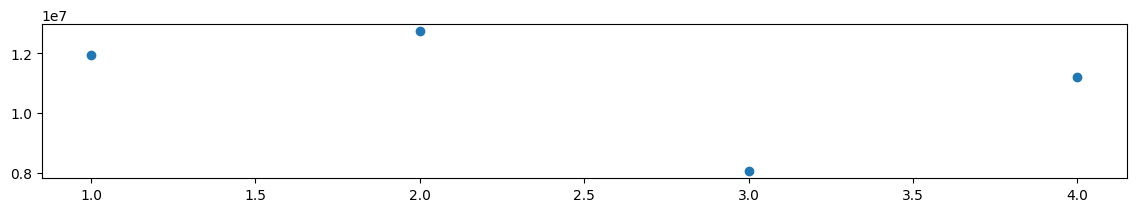

In [39]:
print_grouped_by(group_by_month)

### Exploring multiple columns

Now that we written a function to group by multiple columns.  We can do so with the following. 

And we can write a similar function for printing by multiple columns.

In [87]:
def build_grouped_bys(table_name, cols, target, engine, order_by_col = False):
    grouped_bys = []
    for col in cols:
        grouped = build_grouped_by(table_name, col, target, engine, order_by_col = False)
        grouped_bys.append(grouped)
    return grouped_bys

def print_grouped_bys(cols, grouped_bys):
    for col, group in zip(cols, grouped_bys):
        print(col)
        print_grouped_by(group)

In [88]:
time_cols = ['month', 'week', 'dow', 'hour']
time_cols

['month', 'week', 'dow', 'hour']

In [89]:
time_groups = build_grouped_bys('transactions', time_cols, 'amount', engine, order_by_col = True)

month


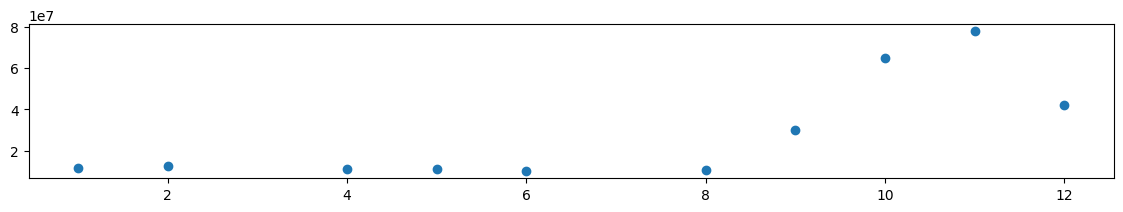

week


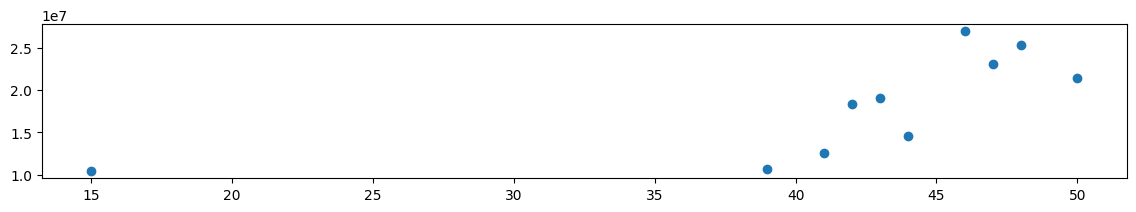

dow


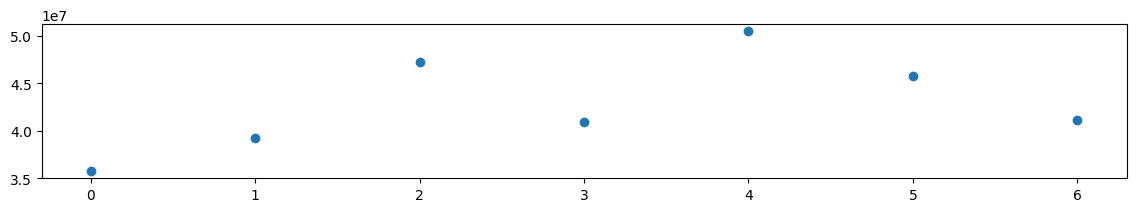

hour


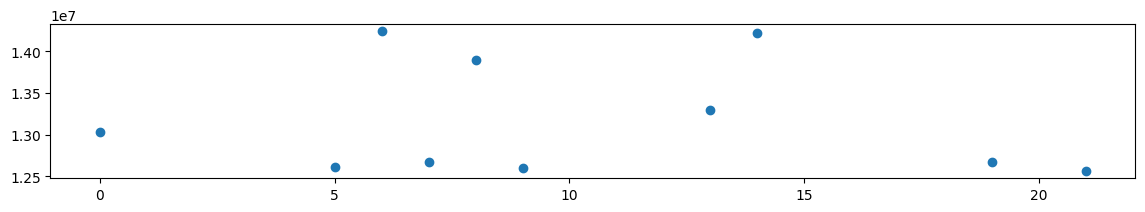

In [90]:
print_grouped_bys(time_cols, time_groups)

And we can combine our two functions to both build and print a set of columns.

In [91]:
def group_and_print(table_name, cols, target, engine, order_by_col = False):
    grouped_bys = build_grouped_bys(table_name, cols, target, engine, order_by_col)
    print_grouped_bys(cols, grouped_bys)

So now if we want to explore another set of data, we can look at our columns, and again select a collection of similar columns.

In [64]:
transactions_df.columns

Index(['index', 'transaction_id', 'customer_id', 'product', 'gender',
       'device_type', 'country', 'state', 'city', 'category',
       'customer_login_type', 'delivery_type', 'quantity', 'transaction_start',
       'transaction_result', 'amount', 'individual_price', 'month', 'week',
       'dow', 'hour'],
      dtype='object')

For example, let's group by and print all of our location columns.

In [65]:
location_cols = ['country', 'state', 'city']

country


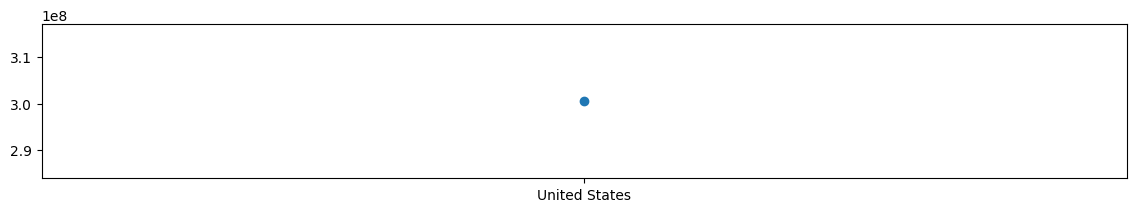

state


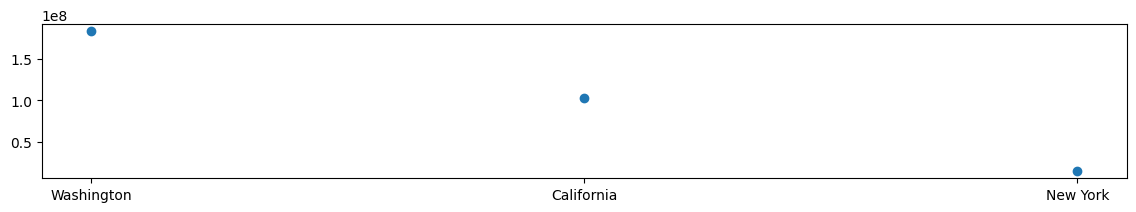

city


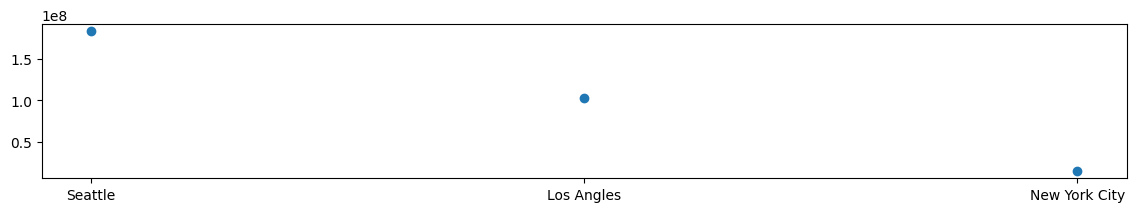

In [92]:
group_and_print('transactions', location_cols, 'amount', engine)

So we can quickly see that most of the sales are on the west coast, in Seattle or Los Angeles.

### Digging Deeper

Finally, there is a way to make more fine grained insights on our data.  For example, so far we have just been grouping by a single column at a time to make sense of our data.

And doing so, for example, we can find the male female split.

In [93]:
gender_grouped_by = build_grouped_by('transactions', 'gender', 'amount', engine)
gender_grouped_by

,gender,total_amount
0,Male,168378026.0
1,Female,132100174.0


So we can see that 43 percent of our transactions are from female users.

In [77]:
132100174/(168378026 + 132100174)

0.4396331381111841

But perhaps there are certain geographic regions that are particularly over or underperforming.  We can explore that either by grouping by multiple columns in sql...or with a pivot table. 

In [72]:
import numpy as np
table = pd.pivot_table(transactions_df, values='amount',
                    columns=['gender'], index = ['city'], aggfunc=np.sum, fill_value=0)
table

gender,Female,Male
city,,
Los Angles,50265822,52540970
New York City,5333893,9150859
Seattle,76500459,106686197


In [79]:
f_values = table['Female']

m_values = table['Male']

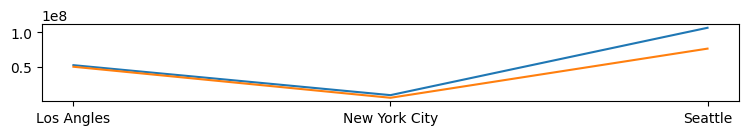

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 1))
plt.plot(table.index, m_values)
plt.plot(table.index, f_values)
plt.show()

So we can see that the biggest gap between men and women is in seattle.  With los angeles having almost no gap.

### Summary

In this lesson, we built a variety of functions to help us quickly explore our data.  Essentially, we write functions that allow us to quickly group our data by specified columns and then print the resulting groups.

### Resources

[Crosstab](https://stackoverflow.com/questions/3002499/postgresql-crosstab-query/11751905#11751905)